In [9]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [10]:
def load_data(path): 
    files = glob.glob(path)
    dfs_split = []
    for file in files: 
        df = pd.read_csv(file, index_col=[0,1], header=[0,1])
        dfs_split.append(df)
    
    return dfs_split

In [13]:
dfs_y_test_split = load_data('../result/gefcom2014-solar/trial22/dfs_y_valid_split/*.csv')
dfs_y_pred_test_model = load_data('../result/gefcom2014-solar/trial22/dfs_y_pred_valid_model/*.csv')

In [20]:
dfs_y_pred_test_model[0]['1']

quantile10  quantile20  quantile30  \
ref_datetime        valid_datetime                                            
2013-05-01 01:00:00 2013-05-01 01:00:00    0.322071    0.397454    0.436752   
                    2013-05-01 02:00:00    0.288139    0.392809    0.425478   
                    2013-05-01 03:00:00    0.272894    0.380541    0.429806   
                    2013-05-01 04:00:00    0.258874    0.310410    0.389935   
                    2013-05-01 05:00:00    0.187936    0.188213    0.209231   
                    2013-05-01 06:00:00    0.105376    0.122117    0.151795   
                    2013-05-01 07:00:00    0.031967    0.034621    0.034725   
                    2013-05-01 08:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 09:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 10:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 11:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 12:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 13:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 14:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 15:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 16:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 17:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 18:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 19:00:00    0.000000    0.000000    0.000000   
                    2013-05-01 20:00:00    0.000006    0.000118    0.000317   
                    2013-05-01 21:00:00    0.001811    0.003856    0.004516   
                    2013-05-01 22:00:00    0.041824    0.071496    0.071796   
                    2013-05-01 23:00:00    0.196805    0.325658    0.404872   
                    2013-05-02 00:00:00    0.547206    0.683653    0.719017   
2013-05-02 01:00:00 2013-05-02 01:00:00    0.570670    0.694614    0.736647   
                    2013-05-02 02:00:00    0.572111    0.696591    0.739043   
                    2013-05-02 03:00:00    0.510979    0.639354    0.690015   
                    2013-05-02 04:00:00    0.459463    0.528529    0.569738   
                    2013-05-02 05:00:00    0.331736    0.404657    0.408704   
                    2013-05-02 06:00:00    0.086032    0.137828    0.167344   
...                                             ...         ...         ...   
2014-05-30 01:00:00 2014-05-30 19:00:00    0.000000    0.000000    0.000000   
                    2014-05-30 20:00:00    0.000000    0.000000    0.000000   
                    2014-05-30 21:00:00    0.000020    0.000142    0.000317   
                    2014-05-30 22:00:00    0.006601    0.009799    0.009837   
                    2014-05-30 23:00:00    0.044301    0.067562    0.071410   
                    2014-05-31 00:00:00    0.160712    0.179765    0.190290   
2014-05-31 01:00:00 2014-05-31 01:00:00    0.155346    0.179971    0.187943   
                    2014-05-31 02:00:00    0.206806    0.210013    0.307078   
                    2014-05-31 03:00:00    0.236420    0.283203    0.295595   
                    2014-05-31 04:00:00    0.180541    0.201820    0.237042   
                    2014-05-31 05:00:00    0.100602    0.104255    0.154315   
                    2014-05-31 06:00:00    0.058573    0.088156    0.092715   
                    2014-05-31 07:00:00    0.011430    0.012671    0.014568   
                    2014-05-31 08:00:00    0.000000    0.000000    0.000000   
                    2014-05-31 09:00:00    0.000000    0.000000    0.000000   
                    2014-05-31 10:00:00    0.000000    0.000000    0.000000   
                    2014-05-31 11:00:00    0.000000    0.000000    0.000000   
                    2014-05-31 12:00:00    0.000000    0.000000    0.000000   
            

## Plot forecast

In [17]:
def plot_quantile_forecast(df_pred, df_y, start_time, end_time, df_clearsky=None, df_physical=None, df_radiation=None):
    df_plot_pred = df_pred.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
    df_plot_true = df_y.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
    
    #return df_plot
    if df_radiation is not None: 
        nrows=2
    else:
        nrows=1
    fig, ax = plt.subplots(nrows=nrows, figsize=(15,5))
    if not isinstance(ax, np.ndarray): ax = [ax]
    quantiles = np.arange(1,100)
    alphas = np.linspace(0.01, 0.1, int(len(quantiles)/2))
    for i in range(int(len(quantiles)/2)):
        ax[0].fill_between(df_plot_pred.index, 
                        df_plot_pred['quantile'+str(i+1)].values, 
                        df_plot_pred['quantile'+str(98-i)].values,
                        color='b', linewidth=0.0, alpha=alphas[i])
    ax[0].plot(df_plot_pred.index, df_plot_pred['quantile50'].values, 'k--', label='median')
    
    if df_clearsky is not None:
        df_plot_clearsky = df_clearsky.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[0].plot(df_plot_clearsky.index, df_plot_clearsky.values, '--', color='orange', label='clearsky')
    if df_physical is not None:
        df_plot_physical = df_physical.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[0].plot(df_plot_physical.index, df_plot_physical.values, '--', color='green', label='median')
    if df_radiation is not None:
        df_radiation = df_radiation.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[1].plot(df_radiation.index, df_radiation.values, '-', color='orange', label='median')
     
        
    ax[0].plot(df_plot_true.index, df_plot_true.values, 'k', label='real')

In [765]:
df_X_test = pd.concat([pd.concat(dfs_X_test_farm[i]) for i in range(3)], keys=['1', '2', '3'], axis=1)
df_pred_test = pd.concat([pd.concat(dfs_y_pred_test_farm[i]) for i in range(3)], keys=['1', '2', '3'], axis=1)
df_y_test = pd.concat([pd.concat(dfs_y_test_farm[i]) for i in range(3)], keys=['1', '2', '3'], axis=1)

In [ ]:
start_time = '2013-05-01'
end_time = '2013-05-15'
dfs_y_pred_test_model[0]['1']
plot_quantile_forecast(dfs_y_pred_test_model[0]['1'], dfs_y_test_split[0]['1'], start_time, end_time, df_clearsky=df_X_test['1']['Clearsky_Forecast'], df_physical=df_X_test['1']['Physical_Forecast'], df_radiation=df_X_test['1']['VAR169'])


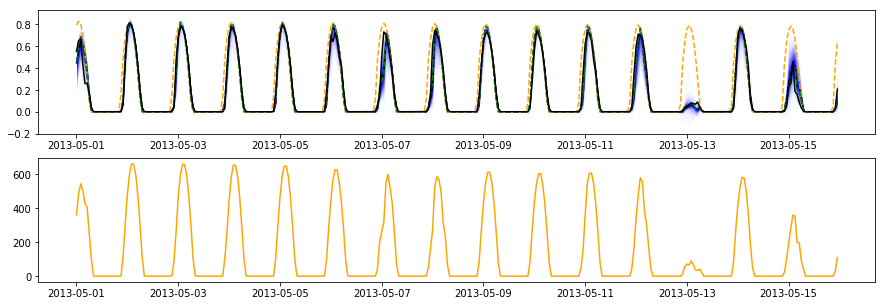

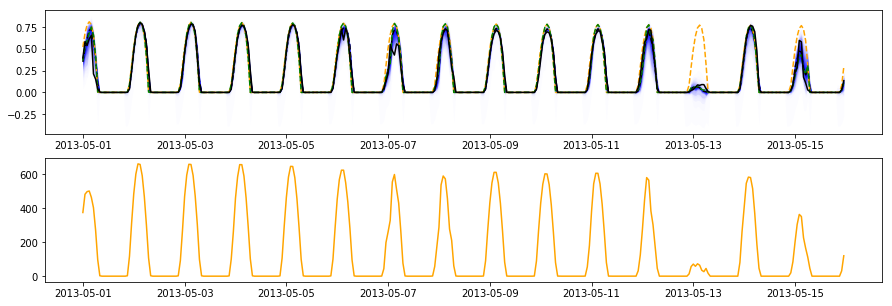

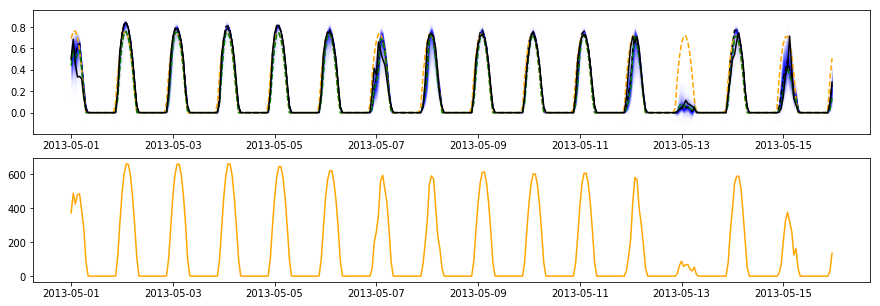

In [768]:
start_time = '2013-05-01'
end_time = '2013-05-15'
plot_quantile_forecast(df_pred_test['1'], df_y_test['1'], start_time, end_time, df_clearsky=df_X_test['1']['Clearsky_Forecast'], df_physical=df_X_test['1']['Physical_Forecast'], df_radiation=df_X_test['1']['VAR169'])
plot_quantile_forecast(df_pred_test['2'], df_y_test['2'], start_time, end_time, df_clearsky=df_X_test['2']['Clearsky_Forecast'], df_physical=df_X_test['2']['Physical_Forecast'], df_radiation=df_X_test['2']['VAR169'])
plot_quantile_forecast(df_pred_test['3'], df_y_test['3'], start_time, end_time, df_clearsky=df_X_test['3']['Clearsky_Forecast'], df_physical=df_X_test['3']['Physical_Forecast'], df_radiation=df_X_test['3']['VAR169'])

## Plot MAE

In [694]:
def plot_mae(df_pred, df_y): 
    dfs_error = []
    for farm in df_pred.columns.levels[0]:
        df_error = df_pred[farm]['quantile50']-df_y[farm]['POWER']
        dfs_error.append(df_error)

    df_error = pd.concat(dfs_error, axis=1, keys=df_pred.columns.levels[0])
    df_mae = df_error.abs().astype(float).groupby(df_error.index.get_level_values(1).hour).mean()
    df_mae.plot(figsize=(10,5))

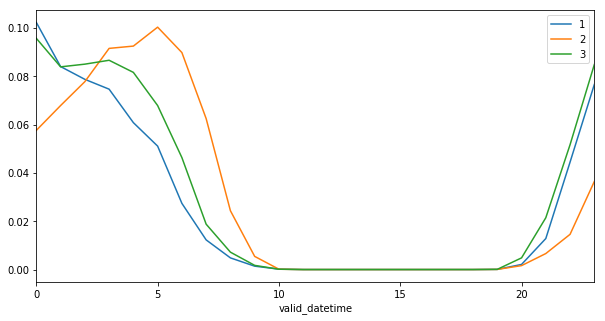

In [697]:
df_pred_train = pd.concat([dfs_y_pred_train_farm[i][14] for i in range(3)], keys=['1', '2', '3'], axis=1)
df_y_train = pd.concat([dfs_y_train_farm[i][14] for i in range(3)], keys=['1', '2', '3'], axis=1)
plot_mae(df_pred_train, df_y_train)

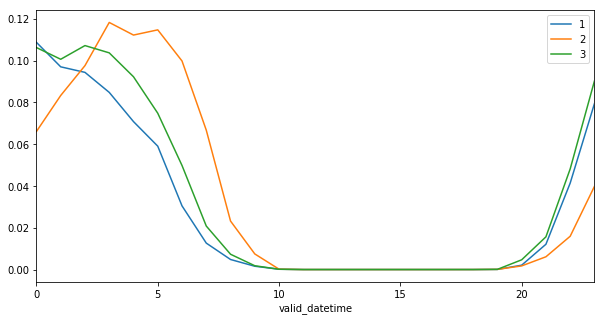

In [698]:
plot_mae(df_pred_test, df_y_test)

## Plot absolute error over year

In [539]:
df_pred_train = pd.concat([pd.concat(dfs_y_pred_train_farm[i]) for i in range(3)], keys=['1', '2', '3'], axis=1)
df_y_train = pd.concat([pd.concat(dfs_y_train_farm[i]) for i in range(3)], keys=['1', '2', '3'], axis=1)

In [546]:
def plot_map_error(df_pred, df_y):
    df_error = (df_pred['quantile50']-df_y['POWER']).abs().astype(float).droplevel(0)
    groups = df_error.groupby([df_error.index.hour, df_error.index.dayofyear])
    plt.figure(figsize=(20,5))
    plt.imshow(error.T, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.show()

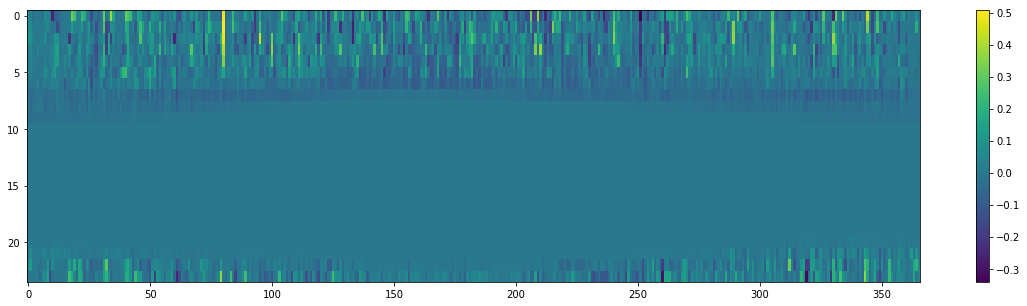

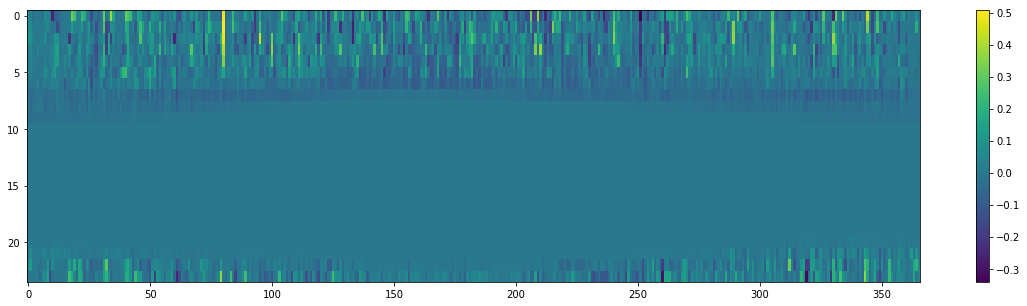

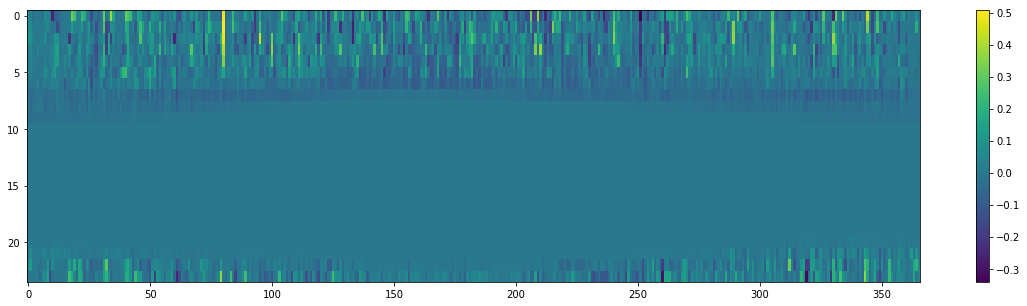

In [548]:
plot_map_error(df_pred_test['1'], df_y_test['1'])
plot_map_error(df_pred_test['2'], df_y_test['2'])
plot_map_error(df_pred_test['3'], df_y_test['3'])

## Scatter plot

In [592]:
def plot_scatters(dfs_y_pred_train_split, dfs_y_train_split, dfs_y_pred_test_split=None, dfs_y_test_split=None):
    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,15), sharex=True, sharey=True)
    ax = ax.flatten()
    for split in range(len(dfs_y_train_split)): 
        ax[split].scatter(dfs_y_train_split[split]['POWER'], dfs_y_pred_train_split[split]['quantile50'], alpha=0.3, label='train' if split==0 else '')
        if not ((dfs_y_pred_test_split == None) or (dfs_y_test_split == None)):
            ax[split].scatter(dfs_y_test_split[split]['POWER'], dfs_y_pred_test_split[split]['quantile50'], alpha=0.3, label='test' if split==0 else '')
        ax[split].set_title('Split: {0}'.format(split))
        if split==0: ax[split].legend()

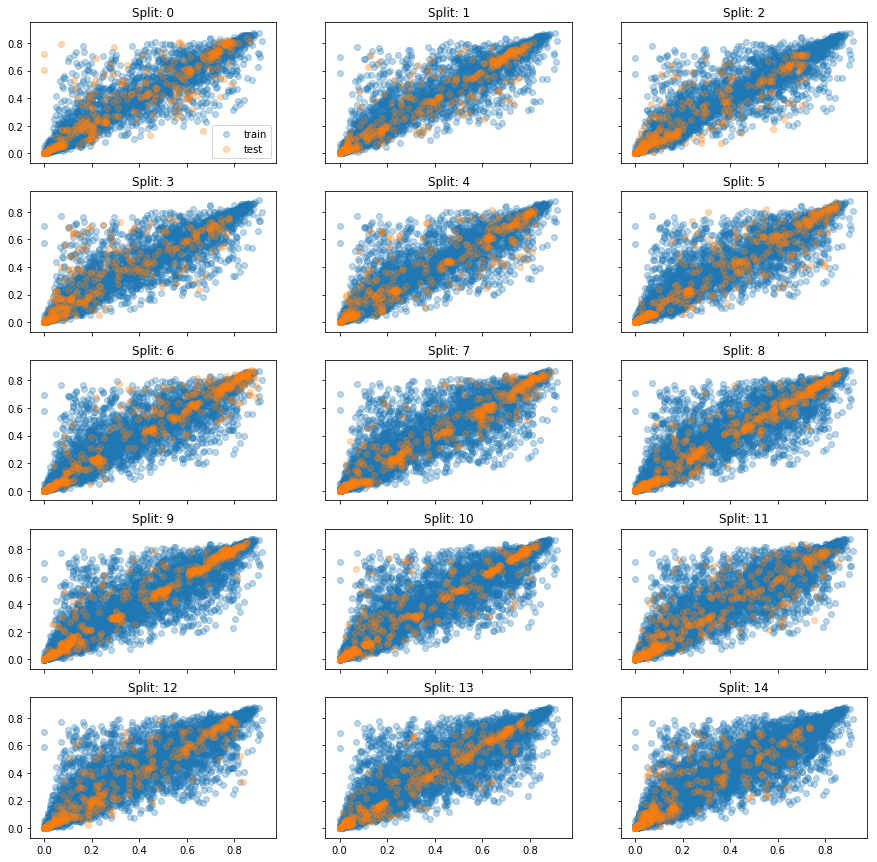

In [593]:
plot_scatters(dfs_y_pred_train_farm[0], dfs_y_train_farm[0],  dfs_y_pred_test_split=dfs_y_pred_test_farm[0], dfs_y_test_split=dfs_y_test_farm[0])

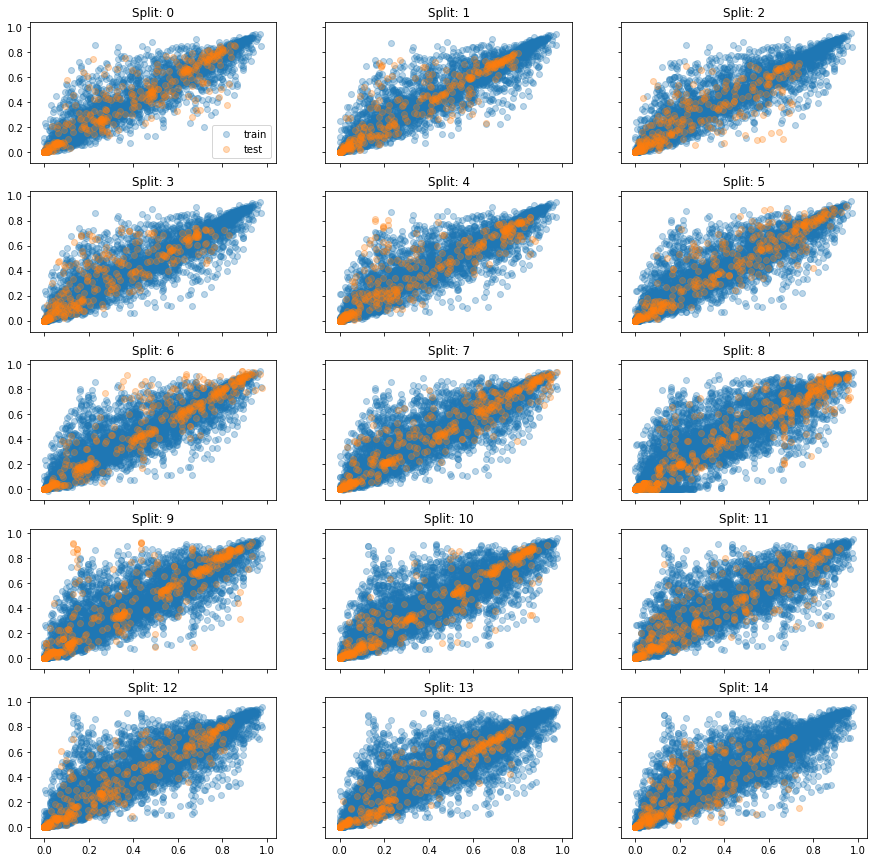

In [594]:
plot_scatters(dfs_y_pred_train_farm[1], dfs_y_train_farm[1],  dfs_y_pred_test_split=dfs_y_pred_test_farm[1], dfs_y_test_split=dfs_y_test_farm[1])

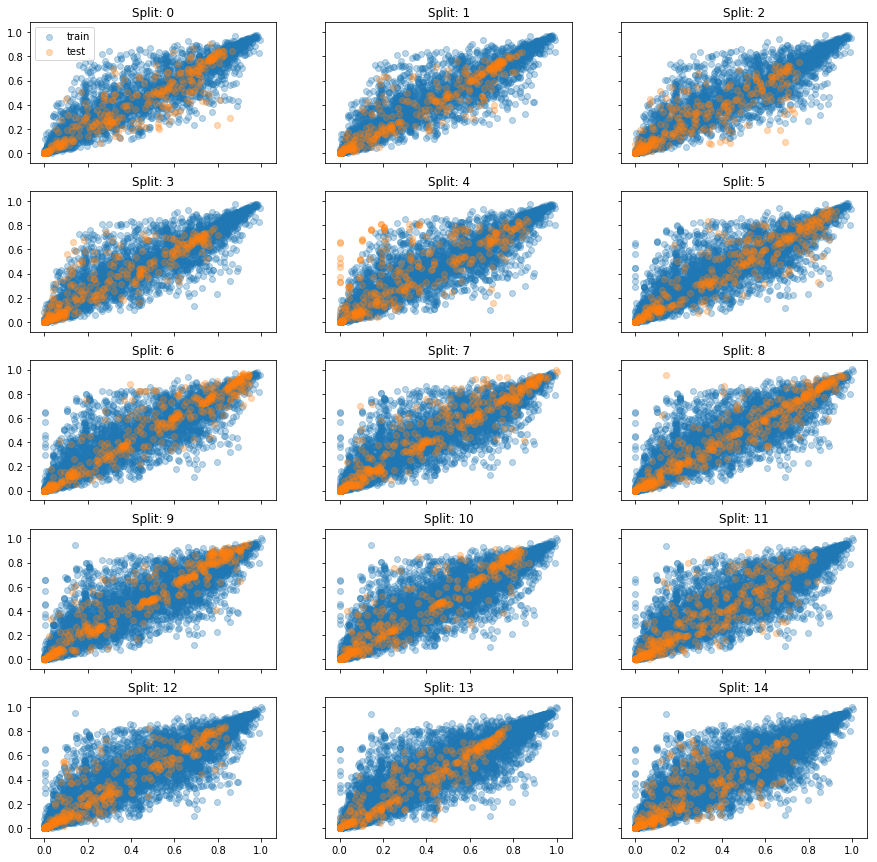

In [595]:
plot_scatters(dfs_y_pred_train_farm[2], dfs_y_train_farm[2],  dfs_y_pred_test_split=dfs_y_pred_test_farm[2], dfs_y_test_split=dfs_y_test_farm[2])

## Plot distributions

In [642]:
def plot_distributions(dfs_y_pred_train_split, dfs_y_train_split, dfs_y_pred_test_split=None, dfs_y_test_split=None): 
    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20,40), sharex=True, sharey=True)
    for split in range(len(dfs_y_train_split)): 
        ax[split,0].hist(dfs_y_train_split[split]['POWER'].astype(float), bins=100, density=True, alpha=0.5, label='true' if split==0 else '');
        ax[split,0].hist(dfs_y_pred_train_split[split]['quantile50'].astype(float), bins=100, density=True, alpha=0.5, label='prediction' if split==0 else '');
        
        if split==0: ax[split,0].legend()        

        if dfs_y_test_split is not None: 
            ax[split,1].hist(dfs_y_test_split[split]['POWER'].astype(float), bins=100, density=True, alpha=0.5);
        if dfs_y_pred_test_split is not None: 
            ax[split,1].hist(dfs_y_pred_test_split[split]['quantile50'].astype(float), bins=100, density=True, alpha=0.5);
        plt.ylim([0,5])

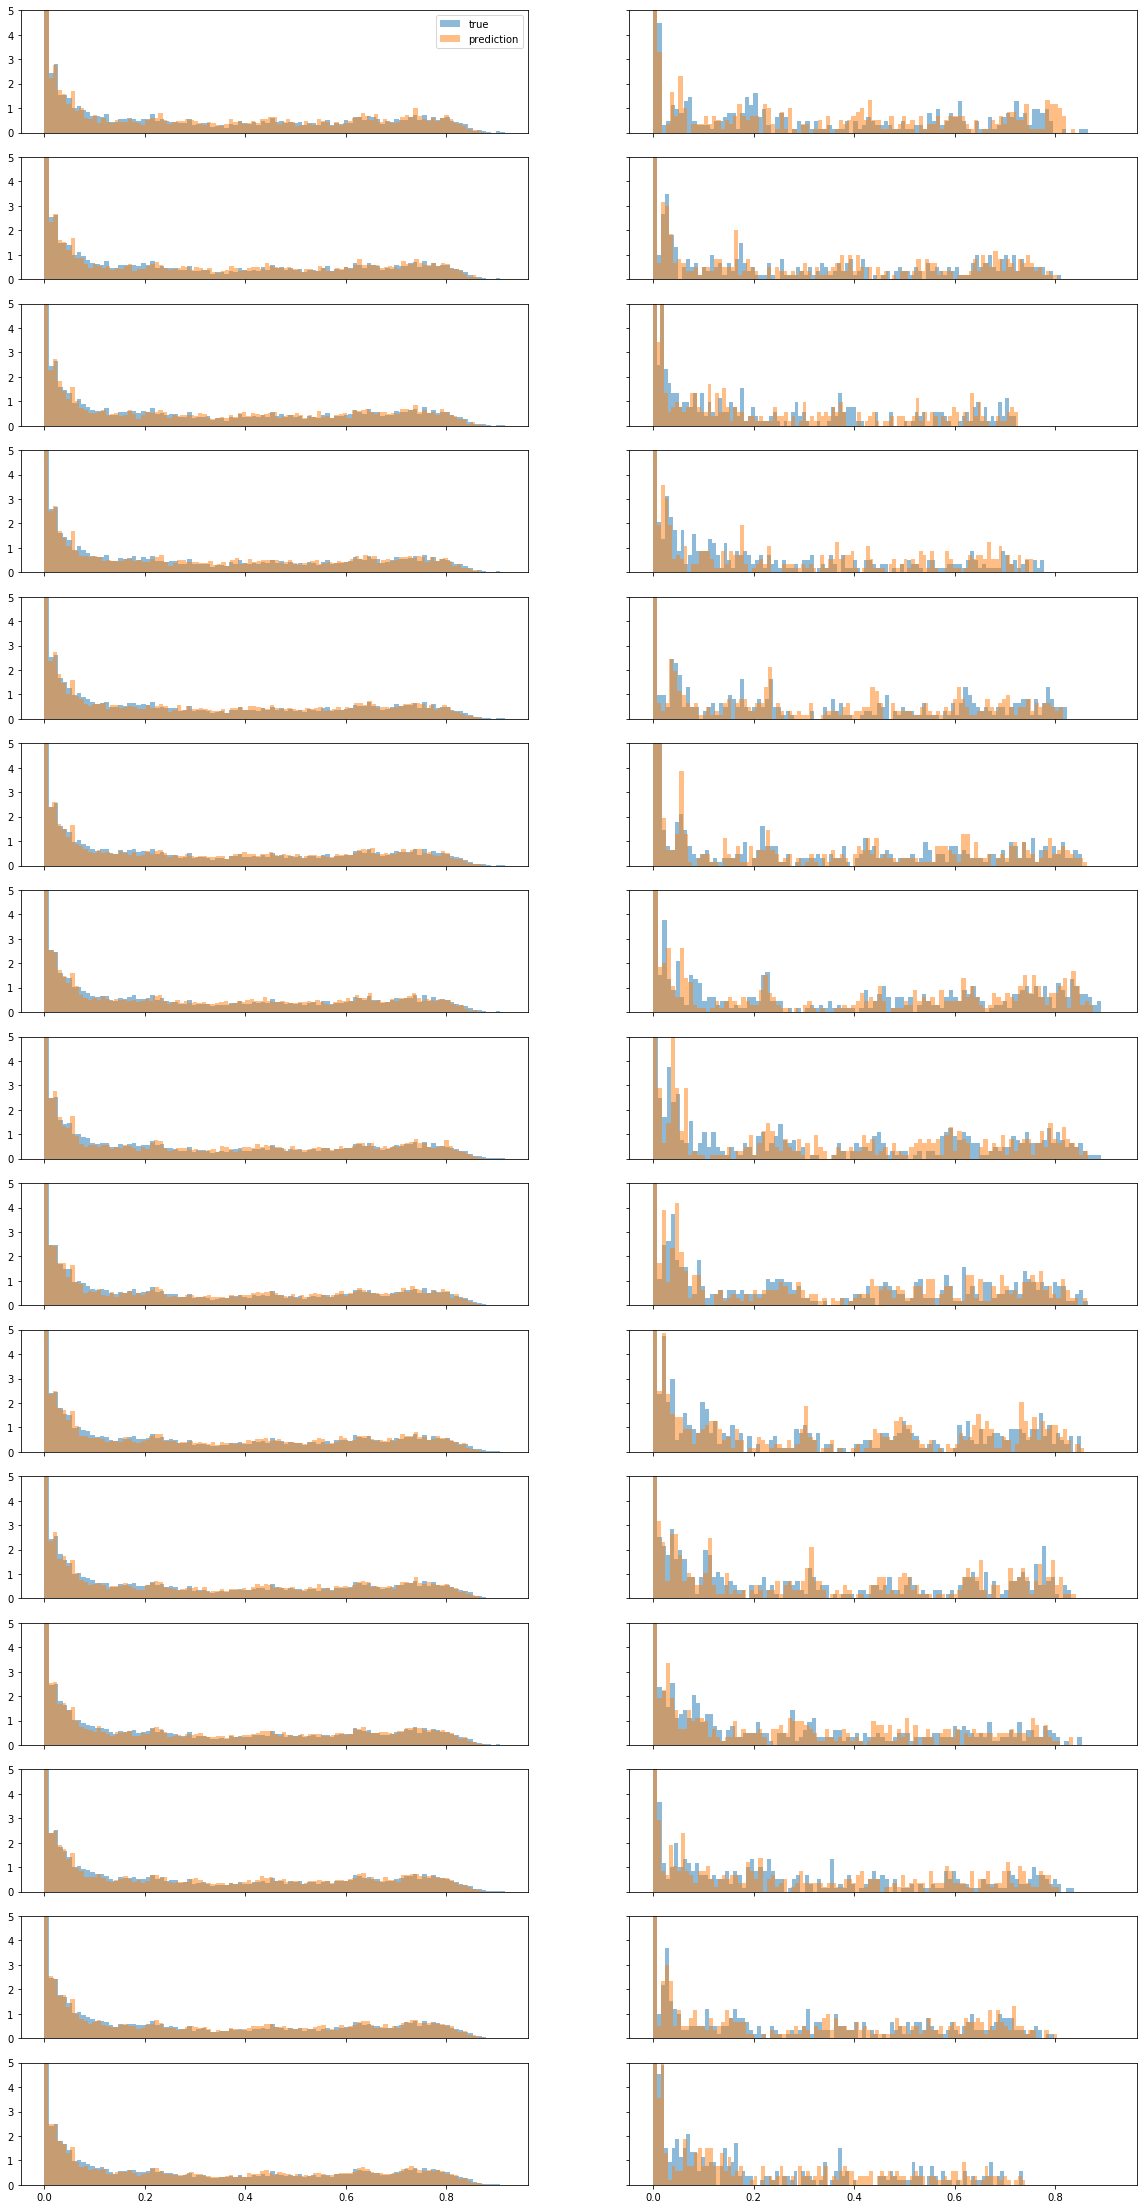

In [643]:
plot_distributions(dfs_y_pred_train_farm[0], dfs_y_train_farm[0], dfs_y_pred_test_split=dfs_y_pred_test_farm[0], dfs_y_test_split=dfs_y_test_farm[0])

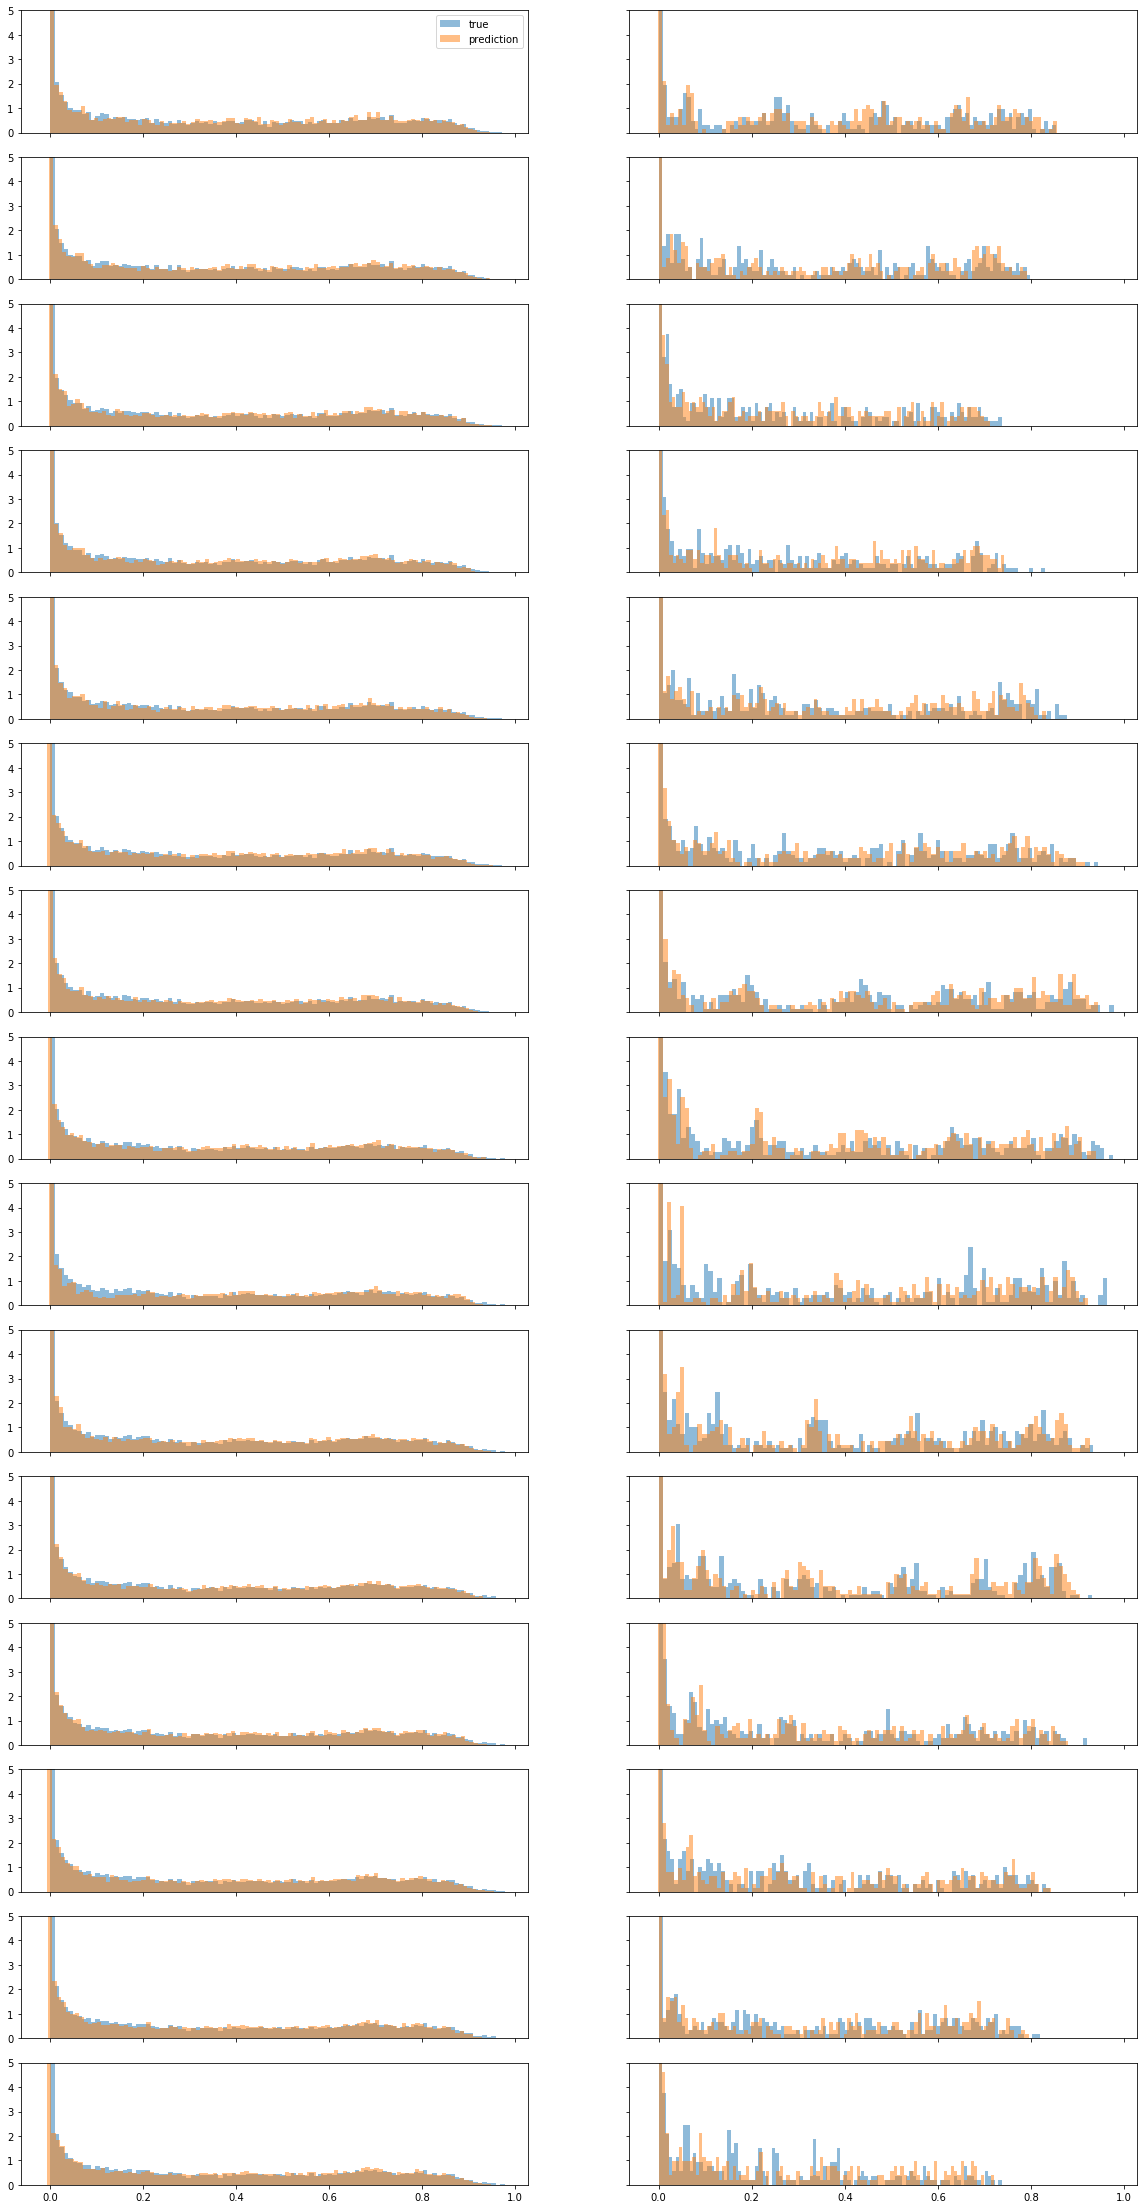

In [644]:
plot_distributions(dfs_y_pred_train_farm[1], dfs_y_train_farm[1], dfs_y_pred_test_split=dfs_y_pred_test_farm[1], dfs_y_test_split=dfs_y_test_farm[1])

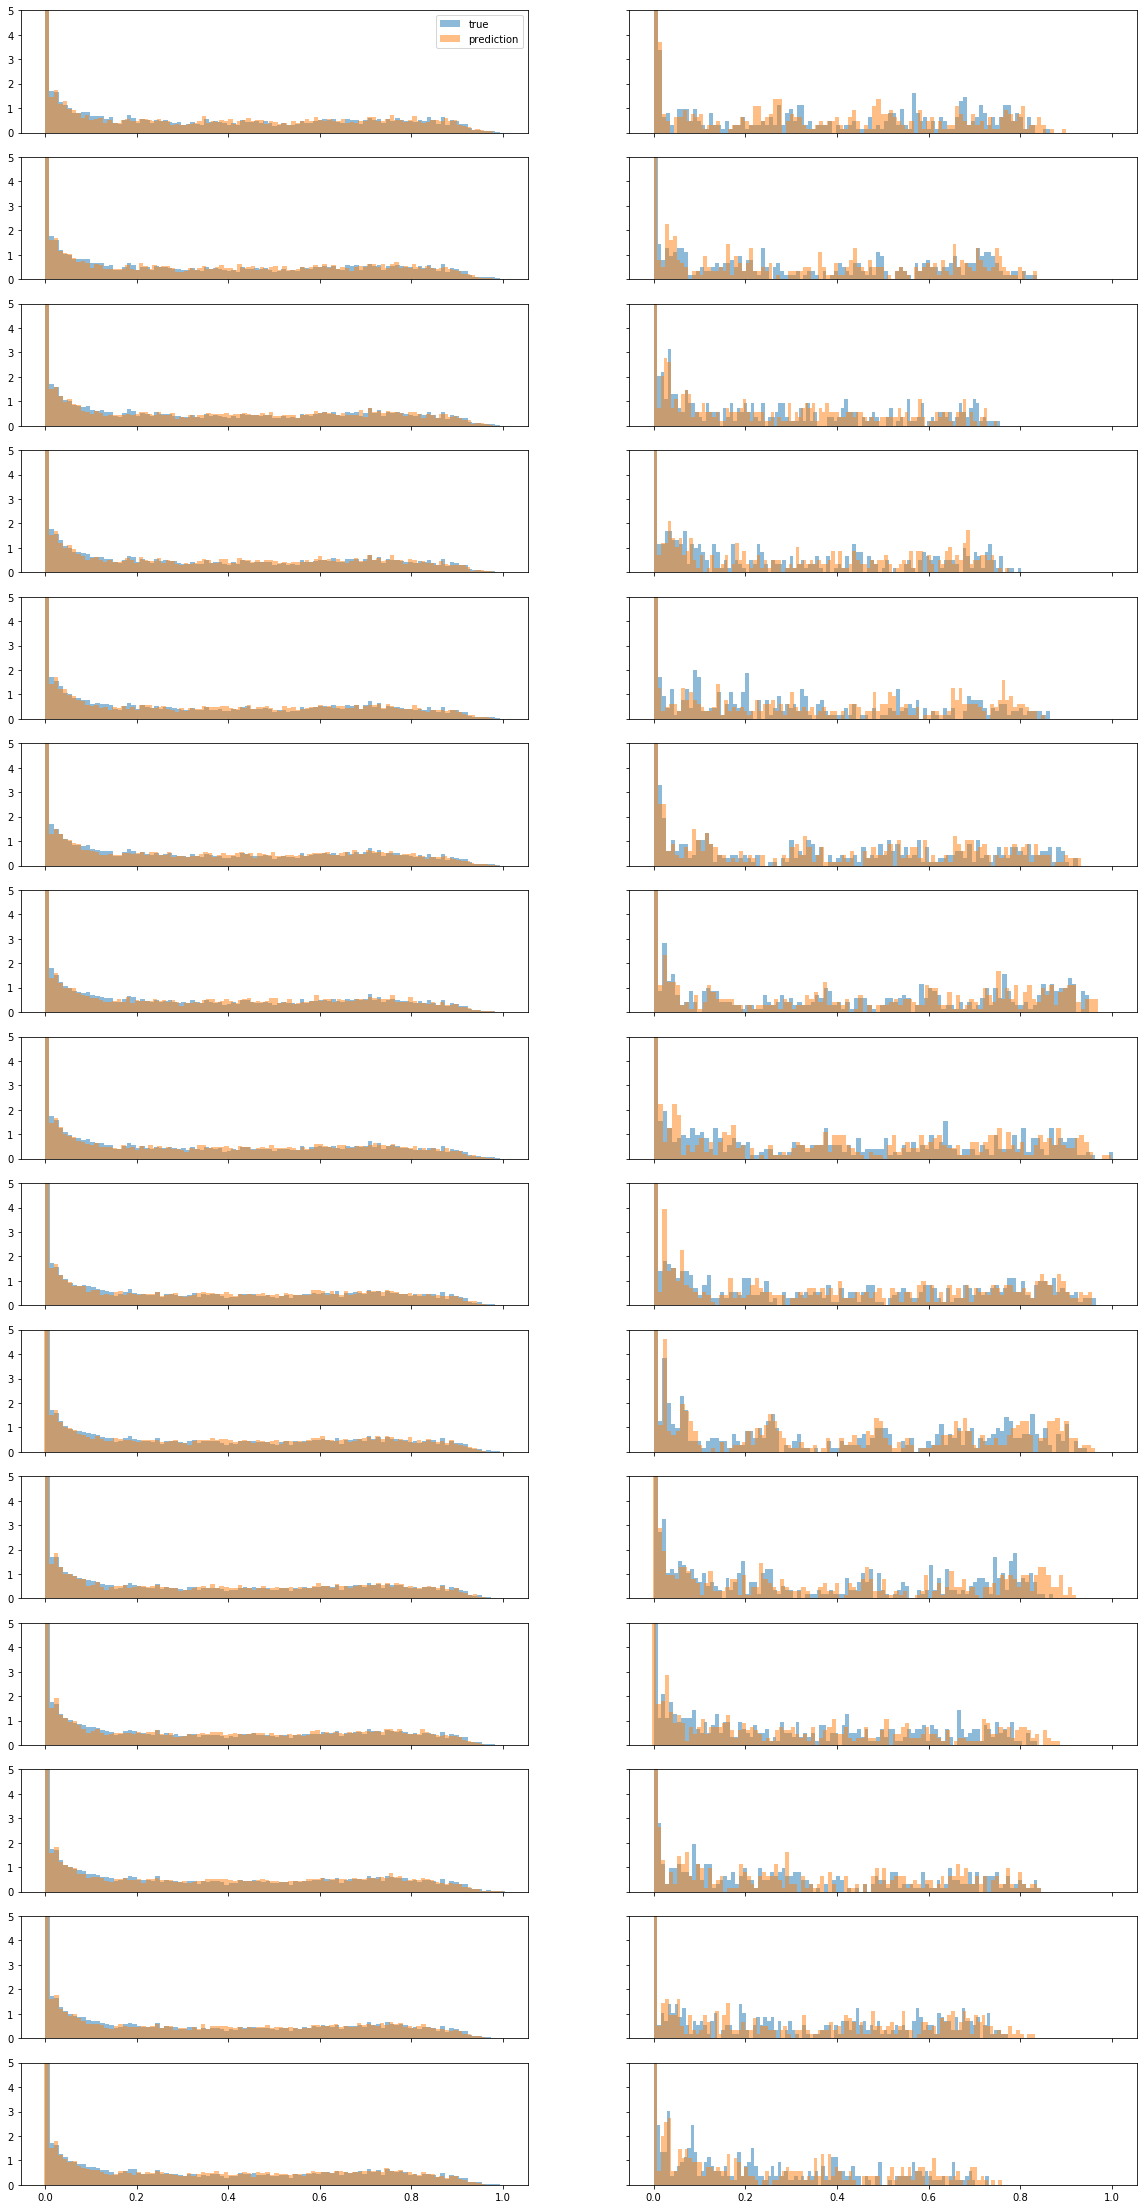

In [645]:
plot_distributions(dfs_y_pred_train_farm[2], dfs_y_train_farm[2], dfs_y_pred_test_split=dfs_y_pred_test_farm[2], dfs_y_test_split=dfs_y_test_farm[2])